1. Bahdanau注意力
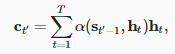
2. 一个带有Bahdanau注意力的循环神经网络编码器-解码器模型
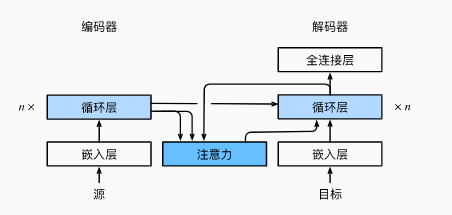


In [3]:
import torch
from torch import nn
import dltools

In [4]:
# 定义注意力解码器
class AttentionDecoder(dltools.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [5]:
# 加入bahdanau注意力
    #1. 编码器在所有时间步的最终层隐状态，将作为注意力的键和值；
    #2. 上一时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
    #3. 编码器有效长度（排除在注意力池中填充词元）。
    
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = dltools.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size) # 7 4 16 → 7 4 10

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        print(outputs.shape,hidden_state.shape)
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens)
        # hidden_state的形状为(num_layers,batch_size,num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        print(X.shape)
        X = self.embedding(X).permute(1, 0, 2)
        print(X.shape)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            print("hidden_state[-1]的形状：")
            print(hidden_state[-1].shape)
            query = torch.unsqueeze(hidden_state[-1], dim=1) # 4 x 16
            print("query形状:")
            print(query.shape)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens) #编码器的输出作为attention的k v
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1) # x由4 x 8 → 4 1 8 与 4 1 16 cat 变成 4 1 24
            print("x的形状：")
            print(x.shape)
            # 将x变形为(1,batch_size,embed_size+num_hiddens) 1 4 24
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            print("解码器输出形状")
            print(out.shape) # 1 4 16
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size) 7 4 10
        outputs = self.dense(torch.cat(outputs, dim=0)) # 将outputs列表第一维度连接再一起 7 4 16 → 7 4 10
        print("解码器最终输出形状")
        print(outputs.shape)
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [6]:
# 使用包含7个时间步的4个序列输入的小批量测试Bahdanau注意力解码器。
encoder = dltools.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

torch.Size([7, 4, 16]) torch.Size([2, 4, 16])
torch.Size([4, 7])
torch.Size([7, 4, 8])
hidden_state[-1]的形状：
torch.Size([4, 16])
query形状:
torch.Size([4, 1, 16])
x的形状：
torch.Size([4, 1, 24])
解码器输出形状
torch.Size([1, 4, 16])
hidden_state[-1]的形状：
torch.Size([4, 16])
query形状:
torch.Size([4, 1, 16])
x的形状：
torch.Size([4, 1, 24])
解码器输出形状
torch.Size([1, 4, 16])
hidden_state[-1]的形状：
torch.Size([4, 16])
query形状:
torch.Size([4, 1, 16])
x的形状：
torch.Size([4, 1, 24])
解码器输出形状
torch.Size([1, 4, 16])
hidden_state[-1]的形状：
torch.Size([4, 16])
query形状:
torch.Size([4, 1, 16])
x的形状：
torch.Size([4, 1, 24])
解码器输出形状
torch.Size([1, 4, 16])
hidden_state[-1]的形状：
torch.Size([4, 16])
query形状:
torch.Size([4, 1, 16])
x的形状：
torch.Size([4, 1, 24])
解码器输出形状
torch.Size([1, 4, 16])
hidden_state[-1]的形状：
torch.Size([4, 16])
query形状:
torch.Size([4, 1, 16])
x的形状：
torch.Size([4, 1, 24])
解码器输出形状
torch.Size([1, 4, 16])
hidden_state[-1]的形状：
torch.Size([4, 16])
query形状:
torch.Size([4, 1, 16])
x的形状：
torch.Size([4, 1, 24])
解码器输出形状
torch

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.061, 1890.6 tokens/sec on cpu


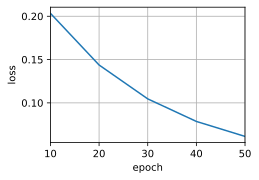

In [7]:
# 训练阶段
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 50, dltools.try_gpu()

train_iter, src_vocab, tgt_vocab = dltools.load_data_nmt(batch_size, num_steps)
encoder = dltools.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = dltools.EncoderDecoder(encoder, decoder)
dltools.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)


In [8]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = dltools.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',f'bleu {dltools.bleu(translation, fra, k=2):.3f}')

torch.Size([10, 1, 32]) torch.Size([2, 1, 32])
torch.Size([1, 1])
torch.Size([1, 1, 32])
hidden_state[-1]的形状：
torch.Size([1, 32])
query形状:
torch.Size([1, 1, 32])
x的形状：
torch.Size([1, 1, 64])
解码器输出形状
torch.Size([1, 1, 32])
解码器最终输出形状
torch.Size([1, 1, 201])
torch.Size([1, 1])
torch.Size([1, 1, 32])
hidden_state[-1]的形状：
torch.Size([1, 32])
query形状:
torch.Size([1, 1, 32])
x的形状：
torch.Size([1, 1, 64])
解码器输出形状
torch.Size([1, 1, 32])
解码器最终输出形状
torch.Size([1, 1, 201])
torch.Size([1, 1])
torch.Size([1, 1, 32])
hidden_state[-1]的形状：
torch.Size([1, 32])
query形状:
torch.Size([1, 1, 32])
x的形状：
torch.Size([1, 1, 64])
解码器输出形状
torch.Size([1, 1, 32])
解码器最终输出形状
torch.Size([1, 1, 201])
go . => va !,  bleu 1.000
torch.Size([10, 1, 32]) torch.Size([2, 1, 32])
torch.Size([1, 1])
torch.Size([1, 1, 32])
hidden_state[-1]的形状：
torch.Size([1, 32])
query形状:
torch.Size([1, 1, 32])
x的形状：
torch.Size([1, 1, 64])
解码器输出形状
torch.Size([1, 1, 32])
解码器最终输出形状
torch.Size([1, 1, 201])
torch.Size([1, 1])
torch.Size([1, 1, 32])
hi